In [6]:
import os
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import defaultdict
from rich.console import Console
from rich.panel import Panel
from rich.table import Table
from rich.progress import track
from rich.theme import Theme
from rich import box

# Initialize Rich console with Dracula theme
dracula_theme = Theme(
    {
        "info": "bold #8be9fd",  # Cyan
        "warning": "bold #f1fa8c",  # Yellow
        "error": "bold #ff5555",  # Red
        "success": "bold #50fa7b",  # Green
        "attacker": "bold #ff79c6",  # Pink
        "defender": "bold #bd93f9",  # Purple
        "header": "bold #f8f8f2 on #44475a",  # Foreground on Current Line
        "setup": "bold #f8f8f2 on #6272a4",  # Foreground on Comment
        "value_high": "bold #50fa7b",  # Green
        "value_medium": "bold #f1fa8c",  # Yellow
        "value_low": "bold #ff5555",  # Red
        "title": "bold #f8f8f2 on #6272a4",  # Foreground on Comment
    }
)

console = Console(theme=dracula_theme)

In [7]:
def extract_hash_key(filename):
    """Extract hash key from log filename."""
    match = re.search(r'log_([a-f0-9]+)_attacker_(.+)_defender_(.+)', filename)
    if match:
        hash_key = match.group(1)
        attacker = match.group(2)
        defender = match.group(3)
        return hash_key, attacker, defender
    return None, None, None

def group_files_by_hash(data_path):
    """Group files by their hash keys."""
    hash_groups = defaultdict(list)
    attacker_strategies = set()
    defender_strategies = set()
    
    # Check if directory exists
    if not os.path.exists(data_path):
        console.print(Panel(f"Directory {data_path} does not exist.", title="Error", style="error"))
        return hash_groups, attacker_strategies, defender_strategies
    
    # Get all JSON files
    json_files = [f for f in os.listdir(data_path) if f.endswith(".json") and f.startswith("log_")]
    console.print(Panel(f"Found {len(json_files)} log files.", title="File Detection", style="info"))
    
    # Group files by hash key
    for filename in track(json_files, description="[info]Grouping files by hash key[/info]"):
        hash_key, attacker, defender = extract_hash_key(filename)
        if hash_key:
            hash_groups[hash_key].append((filename, attacker, defender))
            attacker_strategies.add(attacker)
            defender_strategies.add(defender)
    
    return hash_groups, attacker_strategies, defender_strategies

def extract_summary_from_file(filepath):
    """Extract summary data from a JSON file."""
    try:
        if os.path.getsize(filepath) == 0:
            return None
        
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        # Find summary record
        for record in data.get('records', []):
            if record.get('summary', False):
                return {
                    'payoff': record.get('payoff', 0),
                    'time': record.get('time', 0),
                    'total_captures': record.get('total_captures', 0),
                    'total_tags': record.get('total_tags', 0)
                }
        return None
    except Exception as e:
        console.print(f"[error]Error reading {filepath}: {str(e)}[/error]")
        return None

In [8]:
def extract_metadata_from_file(filepath):
    """Extract metadata from a JSON file."""
    try:
        if os.path.getsize(filepath) == 0:
            return None
        
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        return data.get('metadata', {})
    except Exception as e:
        console.print(f"[error]Error reading metadata from {filepath}: {str(e)}[/error]")
        return None

def compute_payoff_matrix_for_hash(hash_key, files, data_path):
    """Compute payoff matrix for a specific hash key."""
    # Collect attacker and defender strategies for this hash key
    attacker_strategies = set()
    defender_strategies = set()
    summary_data = []
    metadata = None
    
    for filename, attacker, defender in files:
        filepath = os.path.join(data_path, filename)
        
        # Extract summary data
        summary = extract_summary_from_file(filepath)
        if summary:
            summary['attacker'] = attacker
            summary['defender'] = defender
            summary_data.append(summary)
            attacker_strategies.add(attacker)
            defender_strategies.add(defender)
        
        # Extract metadata (we only need one copy since it should be the same for all files with the same hash)
        if metadata is None:
            metadata = extract_metadata_from_file(filepath)
    
    # Skip if no data
    if not summary_data:
        return None, None
    
    # Create dataframe from summary data
    df = pd.DataFrame(summary_data)
    
    # Create payoff matrix
    payoff_matrix = pd.pivot_table(
        df, 
        values='payoff', 
        index='defender', 
        columns='attacker', 
        aggfunc='mean'
    )
    
    # Create captures matrix
    captures_matrix = pd.pivot_table(
        df, 
        values='total_captures', 
        index='defender', 
        columns='attacker', 
        aggfunc='mean'
    )
    
    # Create tags matrix
    tags_matrix = pd.pivot_table(
        df, 
        values='total_tags', 
        index='defender', 
        columns='attacker', 
        aggfunc='mean'
    )
    
    # Create time matrix
    time_matrix = pd.pivot_table(
        df, 
        values='time', 
        index='defender', 
        columns='attacker', 
        aggfunc='mean'
    )
    
    result = {
        'hash_key': hash_key,
        'metadata': metadata,
        'payoff_matrix': payoff_matrix,
        'captures_matrix': captures_matrix,
        'tags_matrix': tags_matrix,
        'time_matrix': time_matrix,
        'file_count': len(files),
        'attacker_strategies': sorted(list(attacker_strategies)),
        'defender_strategies': sorted(list(defender_strategies))
    }
    
    return result, df

def group_hash_results_by_setup(hash_results):
    """Group hash results by setup configuration, primarily agent_num and flag_num."""
    setup_groups = defaultdict(list)
    for hash_key, result in hash_results.items():
        metadata = result.get('metadata', {})
        if metadata:
            # Extract key configuration parameters
            setup_key = {
                'attacker_num': metadata.get('attacker_num'),
                'flag_num': metadata.get('flag_num'),
                'map_size': metadata.get('map_size'),
                'payoff_function': metadata.get('payoff_function')
            }
            # Convert to a hashable key
            setup_key_str = json.dumps(setup_key, sort_keys=True)
            setup_groups[setup_key_str].append(result)
    
    return setup_groups

In [9]:
def evaluate_best_strategies(setup_groups):
    """
    Evaluate and determine the best strategies for each setup by brute force summing the payoffs.
    For each attacker strategy, calculate total payoff against all defender strategies.
    For each defender strategy, calculate total payoff against all attacker strategies.
    """
    setup_scores = {}
    
    for setup_key, results in setup_groups.items():
        # Initialize containers for this setup
        attacker_total_payoffs = defaultdict(float)
        defender_total_payoffs = defaultdict(float)
        attacker_counts = defaultdict(int)
        defender_counts = defaultdict(int)
        
        # Process all matrices for this setup
        for result in results:
            payoff_matrix = result.get('payoff_matrix')
            if payoff_matrix is not None and not payoff_matrix.empty:
                # For each attacker strategy, sum payoffs against all defender strategies
                for attacker in payoff_matrix.columns:
                    for defender in payoff_matrix.index:
                        if not pd.isna(payoff_matrix.loc[defender, attacker]):
                            payoff = payoff_matrix.loc[defender, attacker]
                            attacker_total_payoffs[attacker] += payoff
                            defender_total_payoffs[defender] += 1 - payoff  # Defender payoff is 1 - attacker payoff
                            attacker_counts[attacker] += 1
                            defender_counts[defender] += 1
        
        # Normalize to get average payoffs
        attacker_scores = {a: score / attacker_counts[a] if attacker_counts[a] > 0 else 0 
                          for a, score in attacker_total_payoffs.items()}
        defender_scores = {d: score / defender_counts[d] if defender_counts[d] > 0 else 0 
                          for d, score in defender_total_payoffs.items()}
        
        # Find best strategies
        best_attacker = max(attacker_scores.items(), key=lambda x: x[1], default=(None, 0))
        best_defender = max(defender_scores.items(), key=lambda x: x[1], default=(None, 0))
        
        # Store results
        setup_scores[setup_key] = {
            'attacker_scores': attacker_scores,
            'defender_scores': defender_scores,
            'best_attacker': best_attacker[0],
            'best_attacker_score': best_attacker[1],
            'best_defender': best_defender[0],
            'best_defender_score': best_defender[1],
            'matrix_count': len(results)
        }
    
    return setup_scores

In [10]:
def mix_colors(color_list):
    """Average the RGB channels; boost alpha for visibility."""
    if not color_list:
        return (1, 1, 1, 0)
    r = np.mean([c[0] for c in color_list])
    g = np.mean([c[1] for c in color_list])
    b = np.mean([c[2] for c in color_list])
    # Boost alpha for better visibility but cap at 1.0
    a = min(1.0, sum(c[3] for c in color_list))
    return (r, g, b, a)


def get_strategy_base_name(strategy):
    """Extract base strategy name before any underscore and remove file extension."""
    if not strategy:
        return strategy

    # Remove .json extension if present
    if strategy.endswith(".json"):
        strategy = strategy[:-5]

    # Extract base name before underscore
    if "_" in strategy:
        return strategy.split("_")[0]

    return strategy


def plot_policy_info_grid(policy_info, role, color_dict, organized_results, save_path=None):
    """
    Create a grid plot where x-axis is agent number and y-axis is flag number.
    For each cell (configuration), display the best strategy(ies) with their equilibrium probability.
    """
    # Get unique agent and flag numbers from organized_results keys
    agent_nums = sorted(set(k[0] for k in organized_results.keys()))
    flag_nums = sorted(set(k[1] for k in organized_results.keys()))

    # Handle empty cases
    if not agent_nums or not flag_nums:
        print(f"No data to plot for {role}")
        return None

    # Create figure (making cells wider if needed)
    fig, ax = plt.subplots(figsize=(max(6, len(agent_nums) * 3.5), max(4, len(flag_nums) * 2)))
    ax.set_xlim(-0.05, len(agent_nums) + 0.05)
    ax.set_ylim(-0.05, len(flag_nums) + 0.05)
    ax.invert_yaxis()  # so flag numbers increase upwards

    # Set tick labels
    ax.set_xticks(np.arange(len(agent_nums)) + 0.5)
    ax.set_xticklabels(agent_nums)
    ax.set_yticks(np.arange(len(flag_nums)) + 0.5)
    ax.set_yticklabels(flag_nums)

    # Draw grid lines
    for i in range(len(agent_nums) + 1):
        ax.axvline(i, color="black", linewidth=1)
    for j in range(len(flag_nums) + 1):
        ax.axhline(j, color="black", linewidth=1)

    # Always sort the color_dict keys so the legend is in a consistent order.
    sorted_strategy_names = sorted(color_dict.keys())
    legend_handles = []
    for strategy_name in sorted_strategy_names:
        handle = plt.Rectangle((0, 0), 1, 1, color=color_dict[strategy_name])
        legend_handles.append(handle)

    # Fill in each cell
    for i, flag in enumerate(flag_nums):
        for j, agent in enumerate(agent_nums):
            key = (agent, flag)
            # Skip invalid configurations where flag_num > agent_num
            if flag > agent:
                continue

            if key in policy_info:
                # best_strategy = sorted([(s.replace(".json", ""), p) for s, p in info.items() if np.isclose(p, max_score)], key=lambda x: x[0])
                best_strategy = policy_info[key]
                score = policy_info.get(f"{key}_score", 0)
                if best_strategy:
                    # Get display text
                    annot_text = f"{best_strategy}\n({score:.2f})"

                    # Get color for the strategy
                    base_name = get_strategy_base_name(best_strategy)
                    bg_color = color_dict.get(base_name, (0.9, 0.9, 0.9, 0.3))
                else:
                    annot_text = "None"
                    bg_color = (1, 1, 1, 0)
            else:
                annot_text = "N/A"
                bg_color = (1, 1, 1, 0)

            # Draw background rectangle and text for the cell
            rect = Rectangle((j, i), 1, 1, facecolor=bg_color, edgecolor="none")
            ax.add_patch(rect)
            ax.text(j + 0.5, i + 0.5, annot_text, ha="center", va="center", fontsize=10, wrap=True, linespacing=1.2)

    # Set labels and title
    ax.set_xlabel("Agent Number", fontsize=12)
    ax.set_ylabel("Flag Number", fontsize=12)
    ax.set_title(f"Best {role.capitalize()} Strategy", fontsize=14)
    ax.legend(legend_handles, sorted_strategy_names, title="Strategies", loc="upper left", bbox_to_anchor=(1.25, 1.0), fontsize=10, title_fontsize=12)

    plt.subplots_adjust(left=0.1, right=0.75, top=0.9, bottom=0.1)
    # Save figure
    if save_path:
        save_dir = os.path.dirname(save_path)
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.savefig(f"{role}_best_strategy_grid.png", dpi=300, bbox_inches="tight")

    return fig


def create_phase_diagrams(setup_scores):
    """Create phase diagrams for best strategies by agent/flag combinations."""
    # Define colors for strategies
    COLORS = {"Example": (1, 1, 0, 0.5), "GMU": (1, 0, 0, 0.5), "UNCC": (0, 0, 1, 0.5), "MSU": (0, 1, 0, 0.5)}  # Yellow  # Red  # Blue  # Green

    # For defender, we can use the same colors dictionary
    DEFENDER_COLORS = COLORS.copy()
    ATTACKER_COLORS = COLORS.copy()

    # Extract unique agent/flag configurations and best strategies
    organized_results = {}
    best_defender_info = {}
    best_attacker_info = {}
    best_defender_scores = {}
    best_attacker_scores = {}

    for setup_key, data in setup_scores.items():
        setup = json.loads(setup_key)
        agent_num = setup.get("attacker_num")
        flag_num = setup.get("flag_num")

        if agent_num is None or flag_num is None:
            continue

        # Ensure numbers are integers
        agent_num = int(agent_num)
        flag_num = int(flag_num)

        if agent_num < flag_num:
            continue

        key = (agent_num, flag_num)

        if data["matrix_count"] > 0:
            best_defender_info[key] = data["best_defender"]
            best_attacker_info[key] = data["best_attacker"]
            best_defender_scores[f"{key}_score"] = data["best_defender_score"]
            best_attacker_scores[f"{key}_score"] = data["best_attacker_score"]
            organized_results[key] = True

    # Create save directory for diagrams
    save_dir = "data/strategy_diagrams"
    os.makedirs(save_dir, exist_ok=True)
    def_path = os.path.join(save_dir, "defender_strategy_diagram.png")
    att_path = os.path.join(save_dir, "attacker_strategy_diagram.png")

    # Plot phase diagrams
    plot_policy_info_grid({**best_defender_info, **best_defender_scores}, "defender", DEFENDER_COLORS, organized_results, def_path)
    plot_policy_info_grid({**best_attacker_info, **best_attacker_scores}, "attacker", ATTACKER_COLORS, organized_results, att_path)

    console.print(f"[success]Strategy diagrams saved to {save_dir}[/success]")
    return best_defender_info, best_attacker_info


def create_performance_plots(setup_scores):
    """Create performance plots for strategies across agent and flag numbers."""
    # Extract unique agent and flag numbers
    agent_nums = set()
    flag_nums = set()

    for setup_key in setup_scores:
        setup = json.loads(setup_key)
        if "attacker_num" in setup and "flag_num" in setup:
            agent_nums.add(int(setup["attacker_num"]))
            flag_nums.add(int(setup["flag_num"]))

    agent_nums = sorted(agent_nums)
    flag_nums = sorted(flag_nums)

    plots_dir = "data/strategy_plots"
    os.makedirs(plots_dir, exist_ok=True)

    # Define line styles and markers for visual distinction
    line_styles = ["-", "--", ":", "-."]
    markers = ["o", "s", "^", "D", "v", "*", "x", "+"]

    # Fixed agent plots (varying flag number)
    for agent_num in agent_nums:
        att_data = defaultdict(list)
        def_data = defaultdict(list)

        for setup_key, data in setup_scores.items():
            setup = json.loads(setup_key)
            if int(setup.get("attacker_num", 0)) != agent_num:
                continue

            flag_num = int(setup.get("flag_num", 0))
            if flag_num > agent_num:
                continue

            for strat, score in data["attacker_scores"].items():
                # Remove .json extension if present
                clean_strat = strat.replace(".json", "")
                att_data[clean_strat].append((flag_num, score))

            for strat, score in data["defender_scores"].items():
                # Remove .json extension if present
                clean_strat = strat.replace(".json", "")
                def_data[clean_strat].append((flag_num, score))

        # Only create the plot if we have sufficient data
        if att_data and def_data:
            plt.figure(figsize=(12, 6))

            # Plot attacker performance
            plt.subplot(1, 2, 1)
            for i, (strat, points) in enumerate(sorted(att_data.items())):
                if points and len(points) >= 2:  # Only plot if at least 2 data points
                    xs, ys = zip(*sorted(points))
                    line_style = line_styles[i % len(line_styles)]
                    marker = markers[i % len(markers)]
                    plt.plot(xs, ys, linestyle=line_style, marker=marker, label=strat, alpha=0.7)

            plt.title(f"Attacker Performance (Agent Num={agent_num})")
            plt.xlabel("Flag Number")
            plt.ylabel("Average Score")
            plt.grid(True)
            plt.legend(loc="best", framealpha=0.7)

            # Plot defender performance
            plt.subplot(1, 2, 2)
            for i, (strat, points) in enumerate(sorted(def_data.items())):
                if points and len(points) >= 2:  # Only plot if at least 2 data points
                    xs, ys = zip(*sorted(points))
                    line_style = line_styles[i % len(line_styles)]
                    marker = markers[i % len(markers)]
                    plt.plot(xs, ys, linestyle=line_style, marker=marker, label=strat, alpha=0.7)

            plt.title(f"Defender Performance (Agent Num={agent_num})")
            plt.xlabel("Flag Number")
            plt.ylabel("Average Score")
            plt.grid(True)
            plt.legend(loc="best", framealpha=0.7)

            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, f"perf_agent{agent_num}.png"), dpi=300)
            plt.close()

    # Fixed flag plots (varying agent number)
    for flag_num in flag_nums:
        att_data = defaultdict(list)
        def_data = defaultdict(list)

        for setup_key, data in setup_scores.items():
            setup = json.loads(setup_key)
            if int(setup.get("flag_num", 0)) != flag_num:
                continue

            agent_num = int(setup.get("attacker_num", 0))
            if agent_num < flag_num:
                continue

            for strat, score in data["attacker_scores"].items():
                # Remove .json extension if present
                clean_strat = strat.replace(".json", "")
                att_data[clean_strat].append((agent_num, score))

            for strat, score in data["defender_scores"].items():
                # Remove .json extension if present
                clean_strat = strat.replace(".json", "")
                def_data[clean_strat].append((agent_num, score))

        # Only create the plot if we have sufficient data
        if att_data and def_data:
            plt.figure(figsize=(12, 6))

            # Plot attacker performance
            plt.subplot(1, 2, 1)
            for i, (strat, points) in enumerate(sorted(att_data.items())):
                if points and len(points) >= 2:  # Only plot if at least 2 data points
                    xs, ys = zip(*sorted(points))
                    line_style = line_styles[i % len(line_styles)]
                    marker = markers[i % len(markers)]
                    plt.plot(xs, ys, linestyle=line_style, marker=marker, label=strat, alpha=0.7)

            plt.title(f"Attacker Performance (Flag Num={flag_num})")
            plt.xlabel("Agent Number")
            plt.ylabel("Average Score")
            plt.grid(True)
            plt.legend(loc="best", framealpha=0.7)

            # Plot defender performance
            plt.subplot(1, 2, 2)
            for i, (strat, points) in enumerate(sorted(def_data.items())):
                if points and len(points) >= 2:  # Only plot if at least 2 data points
                    xs, ys = zip(*sorted(points))
                    line_style = line_styles[i % len(line_styles)]
                    marker = markers[i % len(markers)]
                    plt.plot(xs, ys, linestyle=line_style, marker=marker, label=strat, alpha=0.7)

            plt.title(f"Defender Performance (Flag Num={flag_num})")
            plt.xlabel("Agent Number")
            plt.ylabel("Average Score")
            plt.grid(True)
            plt.legend(loc="best", framealpha=0.7)

            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, f"perf_flag{flag_num}.png"), dpi=300)
            plt.close()

    console.print(f"[success]Performance plots saved to {plots_dir}[/success]")

╭──────────────────────────────────────────────── File Detection ─────────────────────────────────────────────────╮
│ Found 6400 log files.                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭─────────────────────────────────────────────────── Hash Keys ───────────────────────────────────────────────────╮
│ Found 400 unique hash keys.                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Strategies ───────────────────────────────────────────────────╮
│ Found 4 unique attacker strategies and 4 unique defender strategies.                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── Matrix Computation ───────────────────────────────────────────────╮
│ Computing payoff matrices for each unique hash key...                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭────────────────────────────────────────────── Processing Complete ──────────────────────────────────────────────╮
│ Successfully processed 400 hash keys.                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Setup Grouping ─────────────────────────────────────────────────╮
│ Grouped results into 8 unique setup configurations.                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── Strategy Evaluation ──────────────────────────────────────────────╮
│ Evaluated best strategies for 8 setup configurations.                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Strategy diagrams saved to data/strategy_diagrams

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Performance plots saved to data/strategy_plots

╭───────────────────────────────────────────────────── Done ──────────────────────────────────────────────────────╮
│ Analysis complete!                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

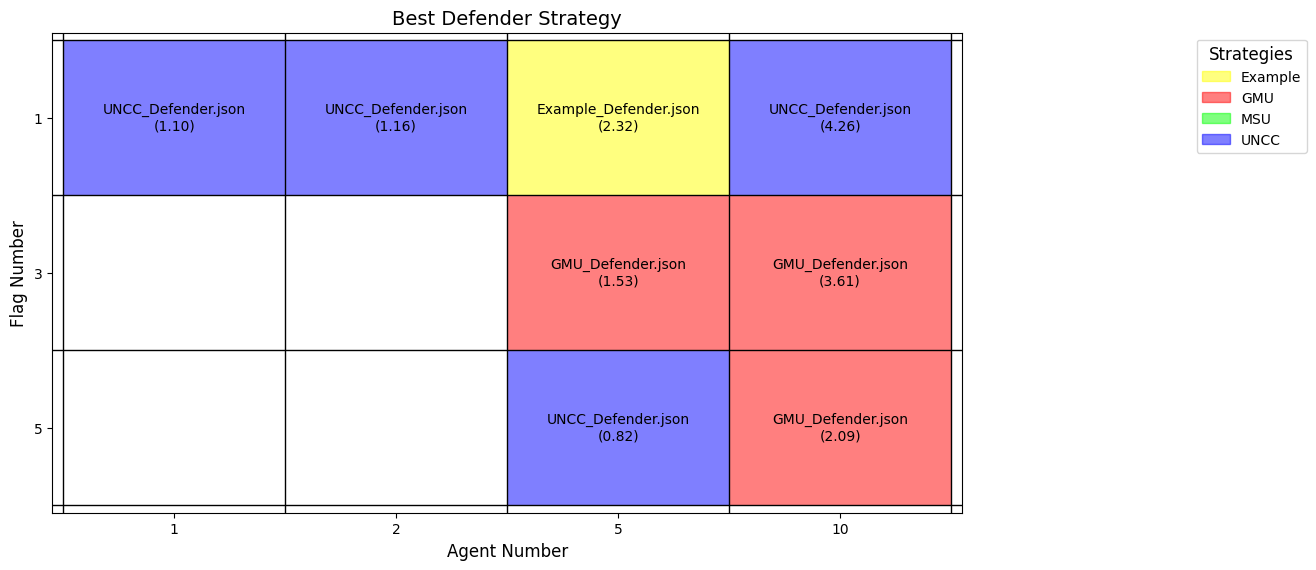

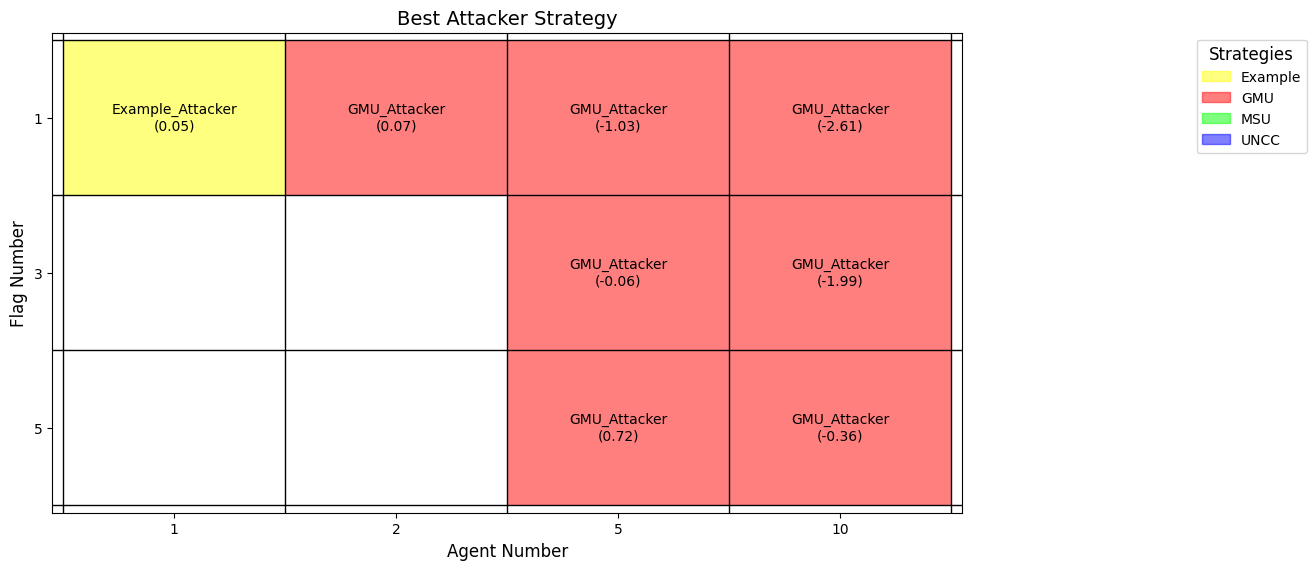

In [11]:
# Set the path to your data directory
DATA_PATH = os.path.join("data", "result_v1.1.1")  # Update this path as needed

# Group files by hash key
hash_groups, attacker_strategies, defender_strategies = group_files_by_hash(DATA_PATH)

# Display summary
console.print(Panel(f"Found {len(hash_groups)} unique hash keys.", title="Hash Keys", style="info"))
console.print(Panel(f"Found {len(attacker_strategies)} unique attacker strategies and {len(defender_strategies)} unique defender strategies.", 
                    title="Strategies", style="info"))

# Compute payoff matrices for each hash key
hash_results = {}

console.print(Panel("[info]Computing payoff matrices for each unique hash key...[/info]", 
                    title="[title]Matrix Computation[/title]", style="setup"))

for hash_key, files in track(hash_groups.items(), description="[info]Computing payoff matrices[/info]"):
    result, _ = compute_payoff_matrix_for_hash(hash_key, files, DATA_PATH)
    if result:
        hash_results[hash_key] = result

console.print(Panel(f"Successfully processed {len(hash_results)} hash keys.", 
                    title="[title]Processing Complete[/title]", style="success"))

# Group hash results by setup configuration
setup_groups = group_hash_results_by_setup(hash_results)
console.print(Panel(f"Grouped results into {len(setup_groups)} unique setup configurations.", 
                    title="[title]Setup Grouping[/title]", style="info"))

# Evaluate best strategies for each setup
setup_scores = evaluate_best_strategies(setup_groups)
console.print(Panel(f"Evaluated best strategies for {len(setup_scores)} setup configurations.", 
                    title="[title]Strategy Evaluation[/title]", style="success"))

# Create visualizations
best_defender_info, best_attacker_info = create_phase_diagrams(setup_scores)
create_performance_plots(setup_scores)

console.print(Panel("Analysis complete!", title="Done", style="success"))